# DS_Course HW_1. Linear Models


В этом ноутбуке используется библиотека `folium` для визуализации карт. Она работает в google colab! Запустив код ниже вы увидете город New York.

In [1]:
import folium

m = folium.Map(location=(40.732804233508006, -74.00414012979357), zoom_start=10)

m

In [2]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="darkgrid")

np.random.seed(0)

## PART 0. Preprocessing

**Task 1**. Мы будем работать с данными из соревнования [New York City Taxi Trip Duration](https://www.kaggle.com/c/nyc-taxi-trip-duration/overview), в котором нужно было предсказать длительность поездки на такси. Скачайте обучающую выборку из этого соревнования и загрузите ее:

In [3]:

!wget -q 'https://www.dropbox.com/scl/fi/gaqtb9wlt4wvgf62znwj5/train_data.csv?rlkey=uvxts7cxwallu5g1euqvt9eq0&dl=0' -O 'train_data.csv'

In [4]:

data = pd.read_csv('train_data.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   id                  1458644 non-null  object 
 1   vendor_id           1458644 non-null  int64  
 2   pickup_datetime     1458644 non-null  object 
 3   dropoff_datetime    1458644 non-null  object 
 4   passenger_count     1458644 non-null  int64  
 5   pickup_longitude    1458644 non-null  float64
 6   pickup_latitude     1458644 non-null  float64
 7   dropoff_longitude   1458644 non-null  float64
 8   dropoff_latitude    1458644 non-null  float64
 9   store_and_fwd_flag  1458644 non-null  object 
 10  trip_duration       1458644 non-null  int64  
dtypes: float64(4), int64(3), object(4)
memory usage: 122.4+ MB


Обратите внимание на колонки `pickup_datetime` и `dropoff_datetime`. `dropoff_datetime` был добавлена организаторами только в обучающую выборку, то есть использовать эту колонку нельзя, давайте удалим ее. В `pickup_datetime` записаны дата и время начала поездки. Чтобы с ней было удобно работать, давайте преобразуем даты в `datetime`-объекты

In [5]:

df=data.copy()

In [6]:

df.drop('dropoff_datetime',axis=1,inplace=True)
df['pickup_datetime']=pd.to_datetime(df['pickup_datetime'])
#√√√√√√√

В колонке `trip_duration` записано целевое значение, которое мы хотим предсказывать. Давайте посмотрим на распределение таргета в обучающей выборке. Для этого нарисуйте его гистограмму:

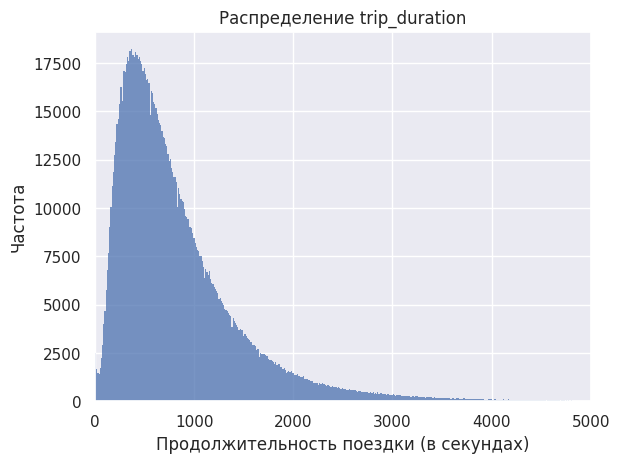

In [7]:

sns.histplot(df['trip_duration'])
plt.xlim(0, 5000)
plt.title('Распределение trip_duration')
plt.xlabel('Продолжительность поездки (в секундах)')
plt.ylabel('Частота')
plt.show()

**Вопрос**: По графику видно что у нас есть выбросы в правой части распределения.

В соревновании в качестве метрики качества использовалось RMSLE:
$$\text{RMSLE}(X, y, a) = \sqrt{\frac{1}{\ell}\sum_{i=1}^{\ell} \big(\log{(y_i + 1)} - \log{(a(x_i) + 1)}\big)^2}$$

**Вопрос**: Как вы думаете, почему авторы соревнования выбрали именно RMSLE, а не RMSE?

*Так как наш график распределения похож на экспоненциальное распределение с длинным хвостом вправо, мы используем RMSLE, а не RMSE. Это помогает сгладить  влияние высоких значений.*

На семинаре мы рассматривали несколько моделей линейной регрессии в `sklearn`, но каждая из них оптимизировала среднеквадратичную ошибку (MSE), а не RMSLE. Давайте проделаем следующий трюк: будем предсказывать не целевую переменную, а ее *логарифм*. Обозначим $\hat{y}_i = \log{(y_i + 1)}$ — модифицированный таргет, а $\hat{a}(x_i)$ — предсказание модели, которая обучалась на $\hat{y}_i$, то есть логарифм таргета. Чтобы предсказать исходное значение, мы можем просто взять экспоненту от нашего предсказания: $a(x_i) = \exp(\hat{a}(x_i)) - 1$.

**Вопрос**: Покажите, что оптимизация RMSLE для модели $a$ эквивалентна оптимизации MSE для модели $\hat{a}$.

**Доказательство**: ...Ваши рассуждения...

Итак, мы смогли свести задачу оптимизации RMSLE к задаче оптимизации MSE, которую мы умеем решать! Кроме того, у логарифмирования таргета есть еще одно полезное свойство. Чтобы его увидеть, добавьте к нашей выборке колонку `log_trip_duration` (воспользуйтесь `np.log1p`) и нарисуйте гистограмму модифицированного таргета по обучающей выборке. Удалите колонку со старым таргетом.

In [8]:
df['log_trip_duration']=np.log1p(df['trip_duration'])
df.drop('trip_duration',axis=1,inplace=True)

In [9]:
#sns.histplot(df['log_trip_duration'])

Чтобы иметь некоторую точку отсчета, давайте посчитаем значение метрики при наилучшем константном предсказании:

In [10]:
def rmsle(log1p_y_true, log1p_y_pred):

    return np.sqrt(np.mean((log1p_y_true - log1p_y_pred) ** 2))

    raise NotImplementedError

rmsle_best_const = rmsle(df['log_trip_duration'],np.mean(df['log_trip_duration']))
print(rmsle_best_const)
assert np.allclose(rmsle_best_const, 0.79575, 1e-4)

0.7957592365411509


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 10 columns):
 #   Column              Non-Null Count    Dtype         
---  ------              --------------    -----         
 0   id                  1458644 non-null  object        
 1   vendor_id           1458644 non-null  int64         
 2   pickup_datetime     1458644 non-null  datetime64[ns]
 3   passenger_count     1458644 non-null  int64         
 4   pickup_longitude    1458644 non-null  float64       
 5   pickup_latitude     1458644 non-null  float64       
 6   dropoff_longitude   1458644 non-null  float64       
 7   dropoff_latitude    1458644 non-null  float64       
 8   store_and_fwd_flag  1458644 non-null  object        
 9   log_trip_duration   1458644 non-null  float64       
dtypes: datetime64[ns](1), float64(5), int64(2), object(2)
memory usage: 111.3+ MB


## PART 2. Изучаем `pickup_datetime`

**Task 2**. Для начала давайте посмотрим, сколько всего было поездок в каждый из дней. Постройте график зависимости количества поездок от дня в году:

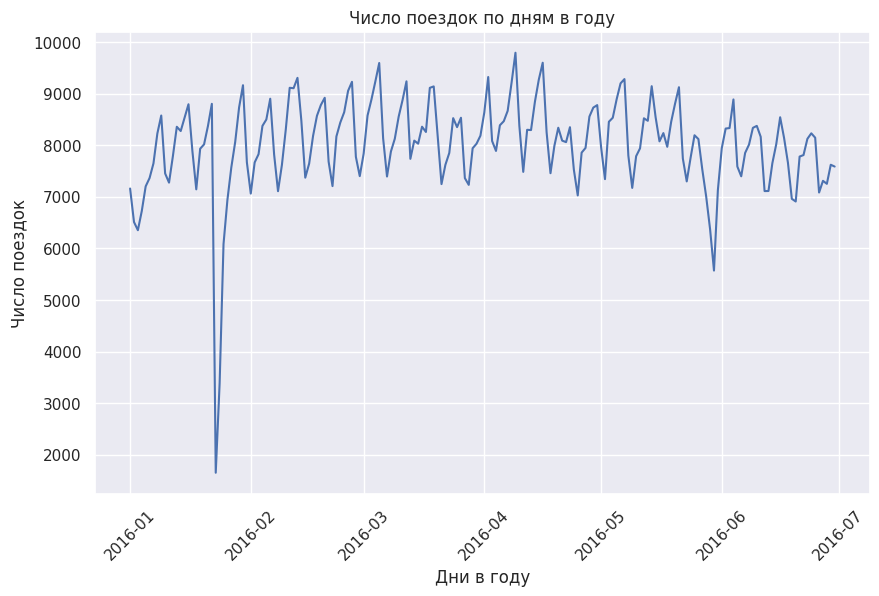

In [12]:
import pandas as pd
import matplotlib.pyplot as plt

df['date'] = df['pickup_datetime'].dt.date
trips_for_day = df.groupby('date').id.count()
plt.figure(figsize=(10, 6))
plt.plot(trips_for_day)
plt.xlabel('Дни в году')
plt.ylabel('Число поездок')
plt.title('Число поездок по дням в году')
plt.xticks(rotation=45)
plt.show()

df=df.drop('date',axis=1)


**Вопрос**: Вы, вероятно, заметили, что на графике есть 2 периода с аномально маленькими количествами поездок. Вычислите, в какие даты происходили эти скачки вниз и найдите информацию о том, что происходило в эти дни в Нью-Йорке.

Нарисуйте графики зависимости количества поездок от дня недели и от часов в сутках (воспользуйтесь `sns.relplot`):

In [13]:
anomalous_dates = trips_for_day.sort_values()[:3].index
formatted_dates = pd.to_datetime(anomalous_dates)
formatted_dates = formatted_dates.strftime('%B %d')
print("Даты с аномальным количеством поездок: ", formatted_dates.values)


Даты с аномальным количеством поездок:  ['January 23' 'January 24' 'May 30']



*23 и 24 января 2016 года шторм Джонас обрушился на Нью-Йорк и другие части восточного побережья США. Это был один из самых сильных зимних штормов за последние годы, приведший к масштабным снегопадам, транспортным сбоям и чрезвычайным ситуациям.
Тысячи авиарейсов были отменены, дороги были заблокированы, общественный транспорт остановлен, и власти призвали людей оставаться дома.*


*30 Мая - День памяти (Memorial Day): Это федеральный праздник в США, который отмечается в последний понедельник мая. В этот день в Нью-Йорке проходили парады и мероприятия в память о военнослужащих, погибших в войнах. Это могло повлиять на привычные маршруты. Многие люди могли уехать на выходные или провести время с семьей, что снизило общее количество поездок.*

<ipython-input-14-93b33d0f826c>:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  trips_for_week = df.groupby('day_of_week').id.count()


([0, 1, 2, 3, 4, 5, 6],
 [Text(0, 0, 'Monday'),
  Text(1, 0, 'Tuesday'),
  Text(2, 0, 'Wednesday'),
  Text(3, 0, 'Thursday'),
  Text(4, 0, 'Friday'),
  Text(5, 0, 'Saturday'),
  Text(6, 0, 'Sunday')])

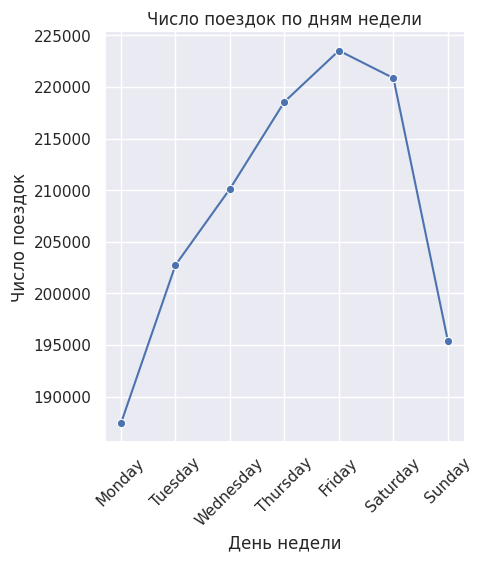

In [14]:
## Графики зависимости количества поездок от дня недели
df['day_of_week']=df['pickup_datetime'].dt.day_name()
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df['day_of_week'] = pd.Categorical(df['day_of_week'], categories=day_order, ordered=True)
trips_for_week = df.groupby('day_of_week').id.count()
sns.relplot(x=trips_for_week.index, y=trips_for_week.values, kind="line", marker="o")
plt.xlabel('День недели')
plt.ylabel('Число поездок')
plt.title('Число поездок по дням недели')
plt.xticks(rotation=45)


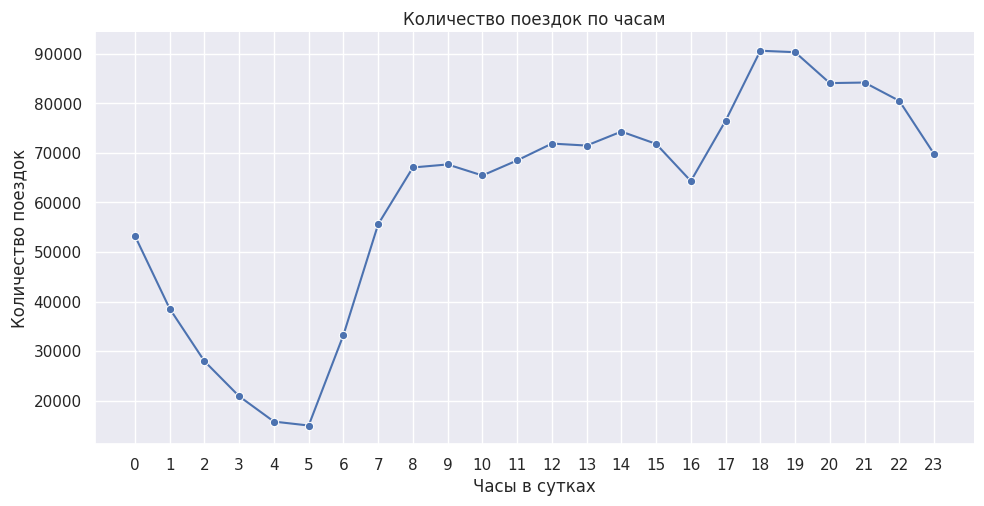

In [15]:
## Графики зависимости количества поездок от часов в сутках (воспользуйтесь sns.relplot):

df['hour']=df['pickup_datetime'].dt.hour
sns.relplot(x='hour', y='id', kind='line', data=df.groupby('hour').id.count().reset_index(),marker='o',aspect=2)
plt.xlabel('Часы в сутках')
plt.ylabel('Количество поездок')
plt.title('Количество поездок по часам')
plt.xticks(ticks=range(24), labels=[f'{hour}' for hour in range(24)])
plt.show()

**Task 3**. Нарисуйте на одном графике зависимости количества поездок от часа в сутках для разных месяцев (разные кривые, соответствующие разным месяцам, окрашивайте в разные цвета, воспользуйтесь `hue` в `sns.relplot`). Аналогично нарисуйте зависимости количества поездок от часа в сутках для разных дней недели.

In [16]:
df['month'] = df['pickup_datetime'].dt.month_name()
df['day']=df['pickup_datetime'].dt.dayofyear

Text(0.5, 1.0, 'График зависимости количества поездок от часа в сутках для разных месяцев')

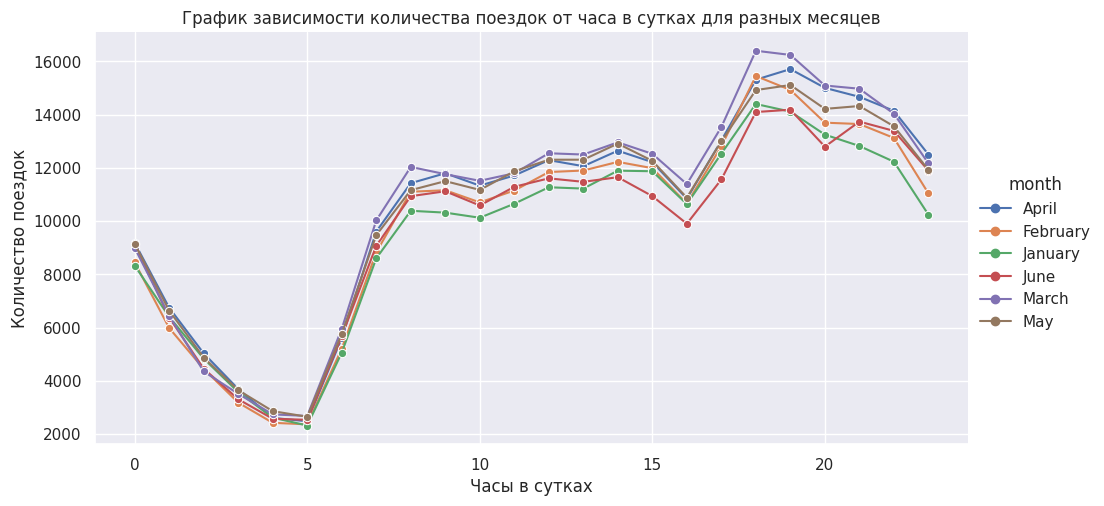

In [17]:
#графике зависимости количества поездок от часа в сутках для разных месяцев .
sns.relplot(x='hour', y='id', kind='line', data=df.groupby(['month','hour']).id.count().reset_index(),marker='o',aspect=2,hue='month')
plt.xlabel('Часы в сутках')
plt.ylabel('Количество поездок')
plt.title('График зависимости количества поездок от часа в сутках для разных месяцев')

<ipython-input-18-504f2c3a7a7b>:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sns.relplot(x='hour', y='id', kind='line', data=df.groupby(['day_of_week','hour']).id.count().reset_index(),marker='o',aspect=2,hue='day_of_week',hue_order=weekday_order)


Text(50.78828125000001, 0.5, 'Количество поездок')

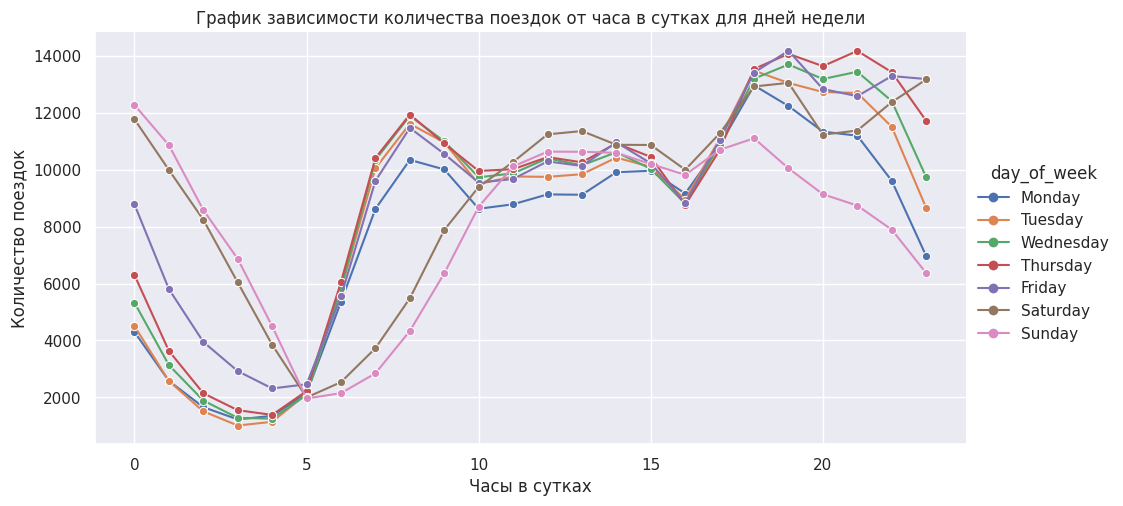

In [18]:
#для недели
weekday_order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
sns.relplot(x='hour', y='id', kind='line', data=df.groupby(['day_of_week','hour']).id.count().reset_index(),marker='o',aspect=2,hue='day_of_week',hue_order=weekday_order)
plt.title('График зависимости количества поездок от часа в сутках для дней недели')
plt.xlabel('Часы в сутках')
plt.ylabel('Количество поездок')

**Вопрос**: Какие выводы можно сделать, основываясь на графиках выше? Выделяются ли какие-нибудь дни недели? Месяца? Время суток? С чем это связано?

**Ответ**: Ранний утренний спад (1-5 утра) : наименьшее количество поездок приходится на период с 1 утра до 5 утра во все дни недели, что соответствует тому, что я упоминал ранее. Это связано с тем, что большинство людей не путешествуют в эти часы, либо из-за сна, либо из-за снижения потребности в транспорте в это время.

Утренний пик (7-9 утра) : заметное увеличение поездок начинается около 6 утра, пик приходится на 7-9 утра. Это соответствует утреннему часу пик, когда люди едут на работу или в школу.

Стабильность в полдень (10:00 - 15:00) : после утреннего пика количество поездок стабилизируется в течение позднего утра и раннего дня. Это, вероятно, отражает рутинные действия, такие как выполнение поручений, поездки на работу в обеденное время или поездки вне пикового времени.

Вечерний пик (с 16:00 до 19:00) : Еще один пик приходится на конец дня и начало вечера, совпадая с вечерним часом пик, когда люди возвращаются домой с работы или учебы.

Вечерний спад (с 20:00 до полуночи) : количество поездок постепенно снижается после вечернего пика, причем более существенное падение наблюдается после 21:00, что отражает окончание большинства дневных активностей.

Различия в выходные дни :

Суббота : в течение дня наблюдается большое количество поездок, картина похожа на будние дни, но кривая немного более пологая, что указывает на более равномерную активность в течение дня.
Воскресенье : График для воскресенья показывает другую картину, с меньшим количеством поездок в течение дня и более низким вечерним пиком. Это может быть связано с тем, что больше людей остаются дома или занимаются меньшим количеством дел по воскресеньям.

**Task 4**. Разбейте выборку на обучающую и тестовую в отношении 7:3 (используйте `train_test_split` из `sklearn`). По обучающей выборке нарисуйте график зависимости среднего логарифма времени поездки от дня недели. Затем сделайте то же самое, но для часа в сутках и дня в году.

<ipython-input-19-413d9ccb84f3>:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sns.lineplot(df_train.groupby('day_of_week').log_trip_duration.mean())


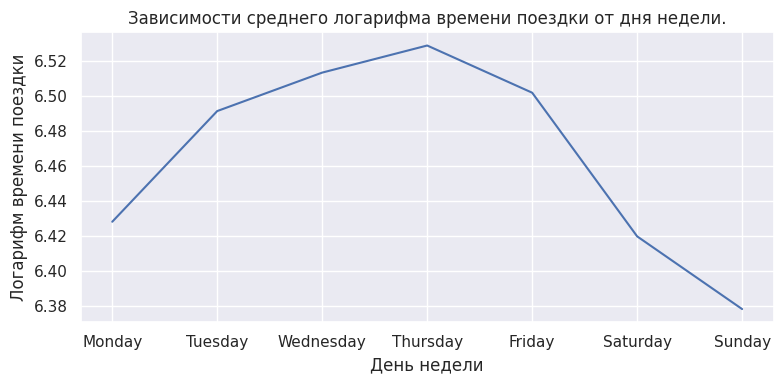

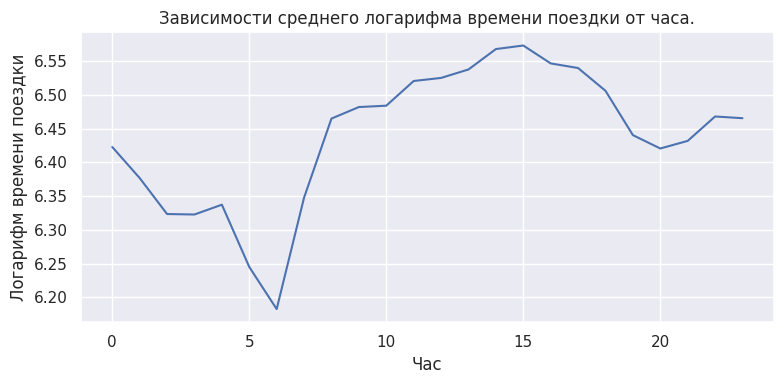

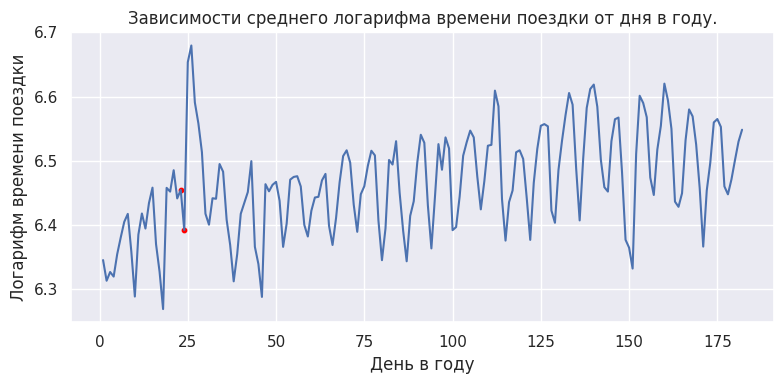

In [19]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

df_train, df_test = train_test_split(df, test_size=.3, random_state=23)

# график зависимости среднего логарифма времени поездки от дня недели.
plt.figure(figsize=(8, 4))
sns.lineplot(df_train.groupby('day_of_week').log_trip_duration.mean())
plt.xlabel('День недели')
plt.ylabel('Логарифм времени поездки')
plt.title('Зависимости среднего логарифма времени поездки от дня недели.')
plt.tight_layout()
plt.show()

# график зависимости среднего логарифма времени поездки от часа.
plt.figure(figsize=(8, 4))
sns.lineplot(df_train.groupby('hour').log_trip_duration.mean())
plt.xlabel('Час')
plt.ylabel('Логарифм времени поездки')
plt.title('Зависимости среднего логарифма времени поездки от часа.')
plt.tight_layout()
plt.show()

# график зависимости среднего логарифма времени поездки от дня в году.
anomalous_dates=df.groupby('day').id.count().sort_values().index[:2].values
plt.figure(figsize=(8, 4))
sns.lineplot(df_train.groupby('day').log_trip_duration.mean())
plt.scatter(anomalous_dates, df_train[df_train['day'].isin(anomalous_dates)].groupby('day')['log_trip_duration'].mean(), color='red', s=10)
plt.xlabel('День в году')
plt.ylabel('Логарифм времени поездки')
plt.title('Зависимости среднего логарифма времени поездки от дня в году.')
plt.tight_layout()
plt.show()




#■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■


**Вопрос**: Похожи ли графики зависимости таргета от дня недели и от часа в сутках на аналогичные графики для количества поездок? Почему? Что происходит со средним таргетом в те два аномальных периода, что мы видели выше? Почему так происходит? Наблюдаете ли вы какой-нибудь тренд на графике зависимости `log_trip_duration` от номера дня в году?
**Ответ:** Да, ест схожесть. Так как при брльшом количестве поездок образуются пробки что увеличивают время поездки.



Добавьте следующие признаки на основе `pickup_datetime`:
1. День недели
2. Месяц
3. Час
4. Является ли период аномальным (два бинарных признака, соответствующие двум аномальным периодам)
5. Номер дня в году

In [20]:
# номер дня в году, час и месяц уже были добавлены в предыдущих заданиях.
trips_for_day = df.groupby('day').vendor_id.count()
anomalous_dates = trips_for_day.sort_values()[:3].index
df ['anomalous_period_1'] = df['day'].map(lambda i: 1 if i==anomalous_dates[0] or i==anomalous_dates[1]  else 0)
df['anomalous_period_2'] = df['day'].map(lambda i: 1 if i==anomalous_dates[2] else 0)
df['day_of_week'] = df['pickup_datetime'].dt.day_name()


In [21]:
df.drop('pickup_datetime',axis=1,inplace=True)

Итак, мы уже создали некоторое количество признаков.

**Вопрос**: Какие из признаков _стоит рассматривать в этой задаче_   как категориальные, а какие - как численные? Почему?



*day_of_week, month, anomalous_period_1, и anomalous_period_2 нужно рассматривать как категориальные, day_of_year и hour количественными так как   увеличение или уменьшение значений в них имеет опрделенную закономерность*



**Task 5**. Обучите `Ridge`-регрессию с параметрами по умолчанию, закодировав все категориальные признаки с помощью `OneHotEncoder`. Численные признаки отмасштабируйте с помощью `StandardScaler`. Используйте только признаки, которые мы выделили в этой части задания.

In [22]:
df['vendor_id'] = df['vendor_id'].astype('object')

In [23]:


from sklearn.preprocessing import StandardScaler

from sklearn.pipeline import Pipeline

from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
features=['hour','month','day','anomalous_period_1','anomalous_period_2','day_of_week']
X = df[features]
y = df['log_trip_duration']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

categorical =X.dtypes[X.dtypes == "object"].index.tolist()
numeric_data = X_train.select_dtypes([np.number])
numeric_features = numeric_data.columns

column_transformer = ColumnTransformer([
    ('encoder', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('scaling', StandardScaler(), numeric_features)
])

pipeline = Pipeline(steps=[
    ('enc_and_scaling', column_transformer),
    ('regression', Ridge())
])

model = pipeline.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("TEST")
print("TEST R2:\t %.4f" % r2_score(y_test, y_pred))
print("TEST MAPE:\t %.4f" % mean_absolute_percentage_error(y_test, y_pred))
print('-----------------')
print("TEST RMSE:\t %.4f" % mean_squared_error(y_test, y_pred, squared=False))
print("TEST MAE:\t %.4f" % mean_absolute_error(y_test, y_pred))


TEST
TEST R2:	 0.0079
TEST MAPE:	 0.1001
-----------------
TEST RMSE:	 0.7919
TEST MAE:	 0.6025


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [24]:

pd.Series(y_pred)
y_test

,log_trip_duration
67250,6.947937
1397036,6.719013
1021087,6.421622
951424,6.766192
707882,8.510773
...,...
876090,6.717805
832420,6.163315
771092,6.171701
1032031,7.038784


In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 15 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   id                  1458644 non-null  object 
 1   vendor_id           1458644 non-null  object 
 2   passenger_count     1458644 non-null  int64  
 3   pickup_longitude    1458644 non-null  float64
 4   pickup_latitude     1458644 non-null  float64
 5   dropoff_longitude   1458644 non-null  float64
 6   dropoff_latitude    1458644 non-null  float64
 7   store_and_fwd_flag  1458644 non-null  object 
 8   log_trip_duration   1458644 non-null  float64
 9   day_of_week         1458644 non-null  object 
 10  hour                1458644 non-null  int32  
 11  month               1458644 non-null  object 
 12  day                 1458644 non-null  int32  
 13  anomalous_period_1  1458644 non-null  int64  
 14  anomalous_period_2  1458644 non-null  int64  
dtypes: float64(5), 

## Part 2. Изучаем координаты
Мы уже очень хорошо изучили данные о времени начала поездки, давайте теперь посмотрим на информацию о координатах начала и конца поездки. Мы подготовили для вас функцию, которая на карте рисует точки начала или конца поездки. Примеры ее вызова вы найдете ниже. Обратите внимание, что в эту функцию мы передаем лишь небольшой кусочек данных, посколько иначе функция будет работать очень долго

In [26]:
def show_circles_on_map(data, latitude_column, longitude_column, color):
    """
    The function draws map with circles on it.
    The center of the map is the mean of coordinates passed in data.

    data: DataFrame that contains columns latitude_column and longitude_column
    latitude_column: string, the name of column for latitude coordinates
    longitude_column: string, the name of column for longitude coordinates
    color: string, the color of circles to be drawn
    """

    location = (data[latitude_column].mean(), data[longitude_column].mean())
    m = folium.Map(location=location)

    for _, row in data.iterrows():
        folium.Circle(
            radius=100,
            location=(row[latitude_column], row[longitude_column]),
            color=color,
            fill_color=color,
            fill=True
        ).add_to(m)



    return m

In [27]:
show_circles_on_map(data.sample(1000), "pickup_latitude", "pickup_longitude", "blue")

In [28]:
show_circles_on_map(data.sample(1000), "dropoff_latitude", "dropoff_longitude", "blue")

**Вопрос**: Какие пункты (или скопления точек, в количестве 2-3), по вашему мнению, выделяются на карте от основной массы и могут быть полезны для нашей задачи? Почему вы их выбрали? В чём особенность этих скоплений точек для нашей задачи?

**Task 6**. Как мы все прекрасно помним, $t = \frac{s}{v_{\text{ср}}}$, поэтому очевидно, что самым сильным признаком будет расстояние, которое необходимо проехать. Мы не можем посчитать точное расстояние, которое необходимо преодолеть такси, но мы можем его оценить, посчитав кратчайшее расстояние между точками начала и конца поездки. Чтобы корректно посчитать расстояние между двумя точками на Земле, можно использовать пример из семинара `Seismic Data`. Сохраните посчитанные расстояния в колонку `haversine`

In [29]:
from geopy import distance
df['haversine'] = df.apply(lambda row: distance.distance(
    (row['pickup_latitude'], row['pickup_longitude']),
    (row['dropoff_latitude'], row['dropoff_longitude'])).kilometers, axis=1)


Так как мы предсказываем логарифм времени поездки и хотим, чтобы наши признаки были линейно зависимы с этой целевой переменной, нам нужно логарифмировать расстояние: $\log t = \log s - \log{v_{\text{ср}}}$. Запишите логарифм `haversine` в отдельную колонку `log_haversine`:

In [30]:
df['log_haversine']=np.log1p(df['haversine'])

Убедимся, что логарифм расстояния лучше коррелирует с нашим таргетом, чем просто расстояние:

In [31]:
corr_haversine = df['haversine'].corr(df['log_trip_duration'])
corr_log_haversine = df['log_haversine'].corr(df['log_trip_duration'])
print(f"Корреляция между 'haversine' и целью: {corr_haversine}")
print(f"Корреляция между 'log_haversine' и целью: {corr_log_haversine}")

Корреляция между 'haversine' и целью: 0.5735496232697034
Корреляция между 'log_haversine' и целью: 0.7499320754122973


**Task 7**. Давайте изучим среднюю скорость движения такси. Посчитайте среднюю скорость для каждого объекта обучающей выборки, разделив `haversine` на `trip_duration`, и нарисуйте гистограмму ее распределения

<Axes: xlabel='avg_speed', ylabel='Count'>

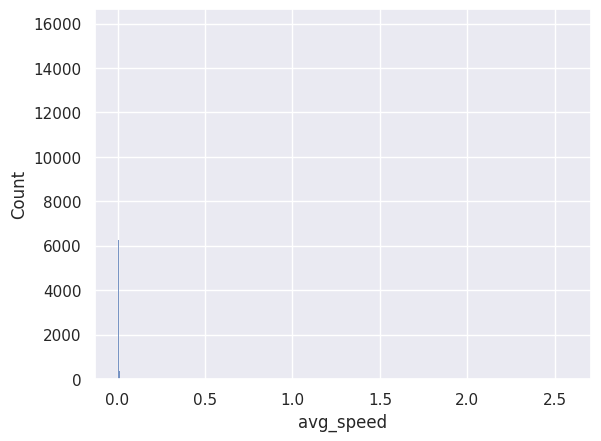

In [32]:
trip_duration_original = np.expm1(df['log_trip_duration'])
df['avg_speed']=df['haversine']/trip_duration_original
sns.histplot(df['avg_speed'])


In [33]:
df=df.drop('haversine',axis=1)

Как можно видеть по гистограмме, для некоторых объектов у нас получились очень больше значения скоростей. Нарисуйте гистограмму по объектам, для которых значение скорости получилось разумным (например, можно не включать рассмотрение объекты, где скорость больше некоторой квантили):

<Axes: xlabel='avg_speed', ylabel='Count'>

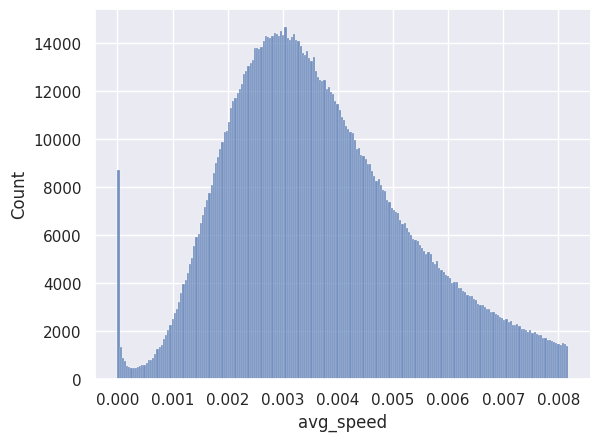

In [34]:
sns.histplot(df[df['avg_speed']<df['avg_speed'].quantile(0.95)].avg_speed)

Для каждой пары (день недели, час суток) посчитайте медиану скоростей. Нарисуйте с помощью `sns.heatmap` график, где по осям будут дни недели и часы, а в качестве значения функции - медиана скорости

<Axes: xlabel='hour', ylabel='day_of_week'>

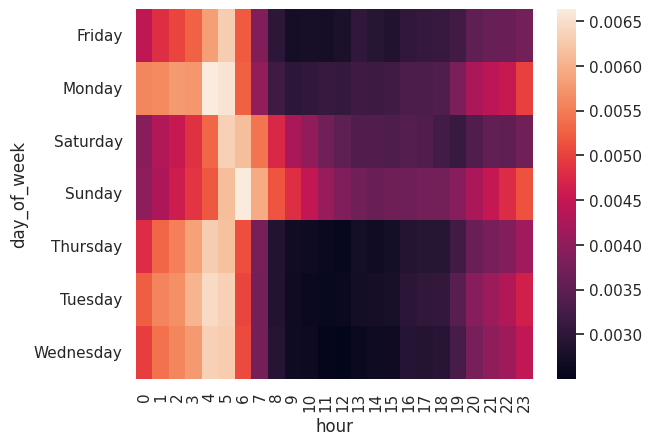

In [35]:
df_pivot = df.pivot_table(index='day_of_week', columns='hour', values='avg_speed', aggfunc='median')

sns.heatmap(df_pivot)

<Axes: xlabel='hour', ylabel='day_of_week'>

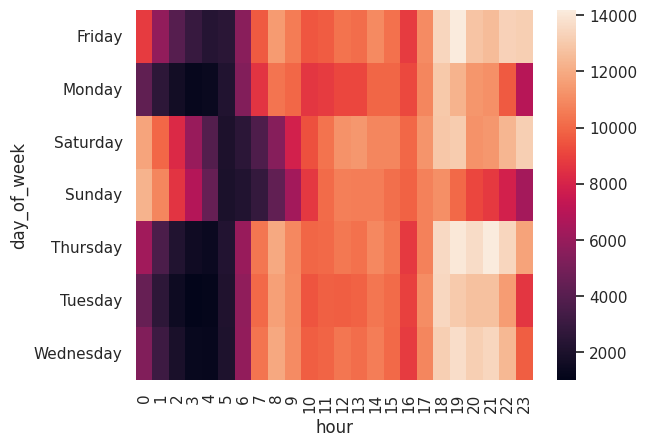

In [36]:
#это график количества поездок
df_pivot = df.pivot_table(index='day_of_week', columns='hour', values='avg_speed', aggfunc='count')
sns.heatmap(df_pivot)



Не забудьте удалить колонку со значением скорости из данных!

**Вопрос**: Почему значение скорости нельзя использовать во время обучения?



*она напрямую зависит от таргета будет утечка данных*

In [37]:
df.drop('avg_speed',axis=1,inplace=True)

**Вопрос**: Посмотрите внимательно на график и скажите, в какие моменты времени скорость минимальна; максимальна.

Создайте признаки "поездка совершается в период пробок" и "поездка совершается в период свободных дорог" (естественно, они не должен зависеть от скорости!):

In [38]:
#так как нельзя использовать скорость то можно определить пробки по количеству поездок

under_quantile=df.groupby(['day_of_week','hour']).id.count().quantile(0.25)
upper_quantile=df.groupby(['day_of_week','hour']).id.count().quantile(0.75)
df['trip_count'] = df.groupby(['day_of_week', 'hour'])['id'].transform('count')
df['rush']=df['trip_count'].map(lambda i: 1 if i<under_quantile else 0)
df['traffic']=df['trip_count'].map(lambda i: 1 if i>upper_quantile else 0)

#можем удалить вспомогательную фичу
df.drop('trip_count',axis=1,inplace=True)

**Task 8**. Для каждого из замеченных вами выше 2-3 пунктов добавьте в выборку по два признака:
- началась ли поездка в этом пункте
- закончилась ли поездка в этом пункте

Как вы думаете, почему эти признаки могут быть полезны?

*Благодаря этим признакам можно понять, каким маршрутом едет машина, что позволяет точнее предсказать время поездки учитывая часто используемые пути.*

In [39]:
pip install hdbscan

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 28.3 MB/s eta 0:00:00


**находим самый большой кластер,**

In [40]:
df_sample=df.sample(10000).copy()


In [41]:
from sklearn.cluster import DBSCAN

eps = 0.01
min_samples = 20
db = DBSCAN(eps=eps, min_samples=min_samples).fit(df_sample[['pickup_latitude', 'pickup_longitude']])
df_sample['dbscan_cluster'] = db.labels_

largest_cluster = df_sample['dbscan_cluster'].value_counts().idxmax()
dense_cluster_points = df_sample[df_sample['dbscan_cluster'] == largest_cluster]


In [42]:
import pandas as pd

# Предполагается, что у вас уже есть определенные зоны на основе кластеров
zones = {}
clusters = df_sample['dbscan_cluster'].unique()

for cluster in clusters:
    if cluster == -1:
        continue
    cluster_points = df_sample[df_sample['dbscan_cluster'] == cluster]
    lat_min = cluster_points['pickup_latitude'].min()
    lat_max = cluster_points['pickup_latitude'].max()
    lon_min = cluster_points['pickup_longitude'].min()
    lon_max = cluster_points['pickup_longitude'].max()

    zones[f'zone_{cluster}'] = {
        'lat_min': lat_min,
        'lat_max': lat_max,
        'lon_min': lon_min,
        'lon_max': lon_max
    }

# Функция для проверки, попадает ли точка в зону
def check_zone(lat, lon, zone, eps=0.05):
    return (zone['lat_min'] - eps <= lat <= zone['lat_max'] + eps) and \
           (zone['lon_min'] - eps <= lon <= zone['lon_max'] + eps)

# Применяем функцию проверки для каждой зоны к полной выборке
for zone_name, zone in zones.items():
    df[f'pickup_in_{zone_name}'] = df.apply(lambda row: int(check_zone(row['pickup_latitude'], row['pickup_longitude'], zone)), axis=1)
    df[f'dropoff_in_{zone_name}'] = df.apply(lambda row: int(check_zone(row['dropoff_latitude'], row['dropoff_longitude'], zone)), axis=1)

# Теперь в df будут новые колонки, указывающие, находится ли точка в каждой из зон


In [43]:

pd.set_option('display.max_columns', None)
df


,id,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,log_trip_duration,day_of_week,hour,month,day,anomalous_period_1,anomalous_period_2,log_haversine,rush,traffic,pickup_in_zone_0,dropoff_in_zone_0,pickup_in_zone_1,dropoff_in_zone_1,pickup_in_zone_2,dropoff_in_zone_2,pickup_in_zone_3,dropoff_in_zone_3,pickup_in_zone_4,dropoff_in_zone_4,pickup_in_zone_5,dropoff_in_zone_5
0,id2875421,2,1,-73.982155,40.767937,-73.964630,40.765602,N,6.122493,Monday,17,March,74,0,0,0.917159,0,0,1,1,0,0,0,0,0,0,1,1,1,1
1,id2377394,1,1,-73.980415,40.738564,-73.999481,40.731152,N,6.498282,Sunday,0,June,164,0,0,1.032707,0,1,1,1,0,0,1,1,0,0,1,0,1,1
2,id3858529,2,1,-73.979027,40.763939,-74.005333,40.710087,N,7.661527,Tuesday,11,January,19,0,0,1.998731,0,0,1,1,0,0,0,1,0,0,1,0,1,1
3,id3504673,2,1,-74.010040,40.719971,-74.012268,40.706718,N,6.063785,Wednesday,19,April,97,0,0,0.909722,0,1,1,1,0,0,1,1,0,0,0,0,1,1
4,id2181028,2,1,-73.973053,40.793209,-73.972923,40.782520,N,6.077642,Saturday,13,March,86,0,0,0.782548,0,1,1,1,0,0,0,0,0,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1458639,id2376096,2,4,-73.982201,40.745522,-73.994911,40.740170,N,6.658011,Friday,13,April,99,0,0,0.800696,0,0,1,1,0,0,1,1,0,0,1,1,1,1
1458640,id1049543,1,1,-74.000946,40.747379,-73.970184,40.796547,N,6.486161,Sunday,7,January,10,0,0,1.952490,1,0,1,1,0,0,1,0,0,0,0,1,1,0
1458641,id2304944,2,1,-73.959129,40.768799,-74.004433,40.707371,N,6.639876,Friday,6,April,113,0,0,2.177196,1,0,1,1,0,0,0,1,0,0,1,0,1,1
1458642,id2714485,1,1,-73.982079,40.749062,-73.974632,40.757107,N,5.924256,Tuesday,15,January,5,0,0,0.738371,0,0,1,1,0,0,1,0,0,0,1,1,1,1


Для каждого из созданных признаков нарисуйте "ящик с усами" (`sns.boxplot`) распределения логарифма времени поездки

In [44]:
show_circles_on_map(df_sample[df_sample['dbscan_cluster']==-1], "pickup_latitude", "pickup_longitude", "blue")

**Вопрос**: судя по графикам, как вы думаете, хорошими ли получились эти признаки?

<img src="https://www.dropbox.com/s/xson9nukz5hba7c/map.png?raw=1" align="right" width="20%" style="margin-left: 20px; margin-bottom: 20px">

**Task 9**. Сейчас мы почти что не используем сами значения координат. На это есть несколько причин: по отдельности рассматривать широту и долготу не имеет особого смысла, стоит рассматривать их вместе. Во-вторых, понятно, что зависимость между нашим таргетом и координатами не линейная. Чтобы как-то использовать координаты, можно прибегнуть к следующему трюку: обрамим область с наибольшим количеством поездок прямоугольником (как на рисунке). Разобьем этот прямоугольник на ячейки. Каждой точке сопоставим номер ее ячейки, а тем точкам, что не попали ни в одну из ячеек, сопоставим значение -1.

Напишите трансформер, который сначала разбивает показанную на рисунке область на ячейки, а затем создает два признака: номер ячейки, в которой началась поездка, и номер ячейки, в которой закончилась поездка. Количество строк и столбцов выберите самостоятельно. В этой задаче можно и нужно поработать командно, так как, вероятно, не все имели дело с парадигмой ООП.

Обратите внимание, что все вычисления должны быть векторизованными, трансформер не должен модифицировать передаваемую ему выборку inplace, а все необходимые статистики (если они вдруг нужны) нужно считать только по обучающей выборке в методе `fit`:

In [45]:
import numpy as np
import pandas as pd
import folium
from folium import plugins
from shapely.geometry import Polygon
from sklearn.base import BaseEstimator, TransformerMixin

class MapGridTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, num_rows=3, num_cols=3):
        self.num_rows = num_rows
        self.num_cols = num_cols

    def fit(self, X=None, y=None):
        if X is not None:
            self.min_longitude = X[X['pickup_in_zone_0'] == 1]['pickup_longitude'].min()
            self.max_longitude = X[X['pickup_in_zone_0'] == 1]['pickup_longitude'].max()
            self.min_latitude = X[X['pickup_in_zone_0'] == 1]['pickup_latitude'].min()
            self.max_latitude = X[X['pickup_in_zone_0'] == 1]['pickup_latitude'].max()
        return self

    def transform(self, X, y=None):
        result = X.copy()
        longitude_range = self.max_longitude - self.min_longitude
        latitude_range = self.max_latitude - self.min_latitude
        if longitude_range == 0 or latitude_range == 0:
            raise ValueError("Longitude or latitude range is zero, cannot transform.")

        def get_cell_number(longitude, latitude):
            col_number = np.floor((longitude - self.min_longitude) / longitude_range * self.num_cols).astype(int)
            row_number = np.floor((latitude - self.min_latitude) / latitude_range * self.num_rows).astype(int)
            col_number = np.clip(col_number, 0, self.num_cols - 1)
            row_number = np.clip(row_number, 0, self.num_rows - 1)
            return row_number * self.num_cols + col_number + 1

        result['pickup_cell'] = np.where(
            (result['pickup_latitude'] < self.min_latitude) | (result['pickup_latitude'] > self.max_latitude) |
            (result['pickup_longitude'] < self.min_longitude) | (result['pickup_longitude'] > self.max_longitude),
            -1,
            get_cell_number(result['pickup_longitude'], result['pickup_latitude'])
        )

        result['dropoff_cell'] = np.where(
            (result['dropoff_latitude'] < self.min_latitude) | (result['dropoff_latitude'] > self.max_latitude) |
            (result['dropoff_longitude'] < self.min_longitude) | (result['dropoff_longitude'] > self.max_longitude),
            -1,
            get_cell_number(result['dropoff_longitude'], result['dropoff_latitude'])
        )

        return result

    def show_map(self, X):
        folium_map = folium.Map(location=[(self.min_latitude + self.max_latitude) / 2,
                                           (self.min_longitude + self.max_longitude) / 2],
                                 zoom_start=14)

        longitude_step = (self.max_longitude - self.min_longitude) / self.num_cols
        latitude_step = (self.max_latitude - self.min_latitude) / self.num_rows

        for row in range(self.num_rows):
            for col in range(self.num_cols):
                cell_polygon = [
                    [self.min_latitude + row * latitude_step, self.min_longitude + col * longitude_step],
                    [self.min_latitude + row * latitude_step, self.min_longitude + (col + 1) * longitude_step],
                    [self.min_latitude + (row + 1) * latitude_step, self.min_longitude + (col + 1) * longitude_step],
                    [self.min_latitude + (row + 1) * latitude_step, self.min_longitude + col * longitude_step],
                    [self.min_latitude + row * latitude_step, self.min_longitude + col * longitude_step]
                ]

                folium.Polygon(locations=cell_polygon,
                               color='blue',
                               fill=True,
                               fill_opacity=0.1).add_to(folium_map)

                cell_number = row * self.num_cols + col + 1
                folium.Marker(location=[(self.min_latitude + (row + 0.5) * latitude_step),
                                         (self.min_longitude + (col + 0.5) * longitude_step)],
                              popup=str(cell_number),
                              icon=folium.Icon(color='red')).add_to(folium_map)

        folium.Marker(location=[X['pickup_latitude'].mean(), X['pickup_longitude'].mean()],
                      icon=folium.Icon(color='green', icon='info-sign'),
                      popup='Pickup Points').add_to(folium_map)

        folium.Marker(location=[X['dropoff_latitude'].mean(), X['dropoff_longitude'].mean()],
                      icon=folium.Icon(color='orange', icon='info-sign'),
                      popup='Dropoff Points').add_to(folium_map)

        return folium_map


In [46]:
transformer = MapGridTransformer(num_rows=9, num_cols=4)
transformer.fit(df)
df=transformer.transform(df)



In [47]:
transformer.show_map(df)

In [48]:
df['pickup_cell']=df['pickup_cell'].astype(str)
df['dropoff_cell']=df['dropoff_cell'].astype(str)

**Task 10**. Обучите `Ridge`-регрессию со стандартными параметрами на признаках, которые мы выделили к текущему моменту. Категориальные признаки закодируйте через one-hot-кодирование, числовые признаки отмасштабируйте.

In [49]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge,Lasso
from sklearn.metrics import mean_squared_log_error


X = df.drop(['id','log_haversine','log_trip_duration','store_and_fwd_flag' 	,'vendor_id','passenger_count','pickup_longitude', 'pickup_latitude', 'dropoff_latitude', 'dropoff_longitude'], axis=1)
y = df['log_trip_duration']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

numeric_features = X.select_dtypes(include='number').columns.tolist()
categorical_features = X.select_dtypes(include='object').columns.tolist()

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(), categorical_features)
    ])

model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', Ridge())
])

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

rmsle_score = rmsle(y_test, y_pred)
print(f'RMSLE Score: {rmsle_score:.4f}')


RMSLE Score: 0.7225


## PART 3. Изучаем оставшиеся признаки

**Task 11**. У нас осталось еще 3 признака, которые мы не исследовали: `vendor_id`, `passenger_count` и `store_and_fwd_flag`.

**Вопрос**: Подумайте, почему каждый из этих признаков может быть потенциально полезным.

Посчитайте, сколько есть уникальных значений у каждого из этих признаков:

In [50]:
unique_vendor_id=len(df['vendor_id'].unique())
unique_passenger_count=len(df['passenger_count'].unique())
unique_store_and_fwd_flag=len(df['store_and_fwd_flag'].unique())
print(f'vendor_id: {unique_vendor_id} уникальных значения')
print(f'unique_passenger_count: {unique_passenger_count} уникальных значения')
print(f'unique_store_and_fwd_flag: {unique_store_and_fwd_flag} уникальных значения')
df['passenger_count_cat'] = df['passenger_count'].astype('category')


vendor_id: 2 уникальных значения
unique_passenger_count: 10 уникальных значения
unique_store_and_fwd_flag: 2 уникальных значения


Постройте "ящики с усами" распределений логарифма времени поездки в зависимости от значений каждого из признаков

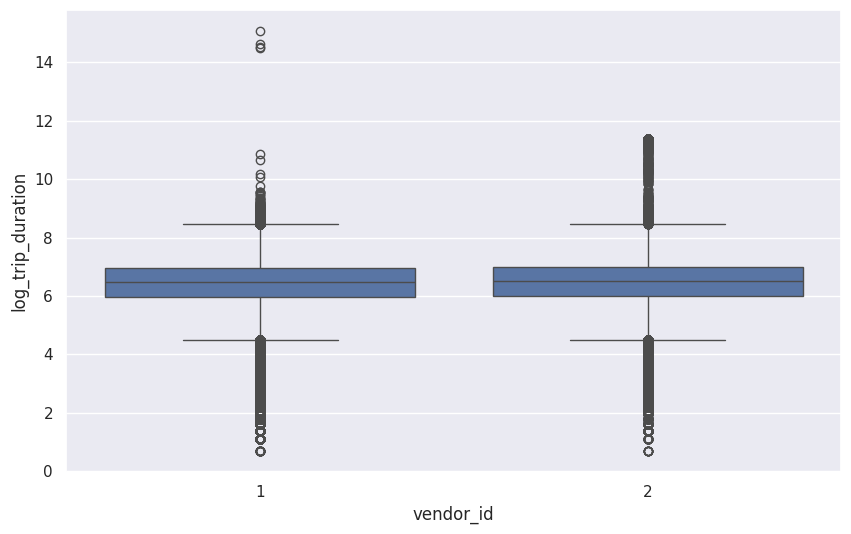

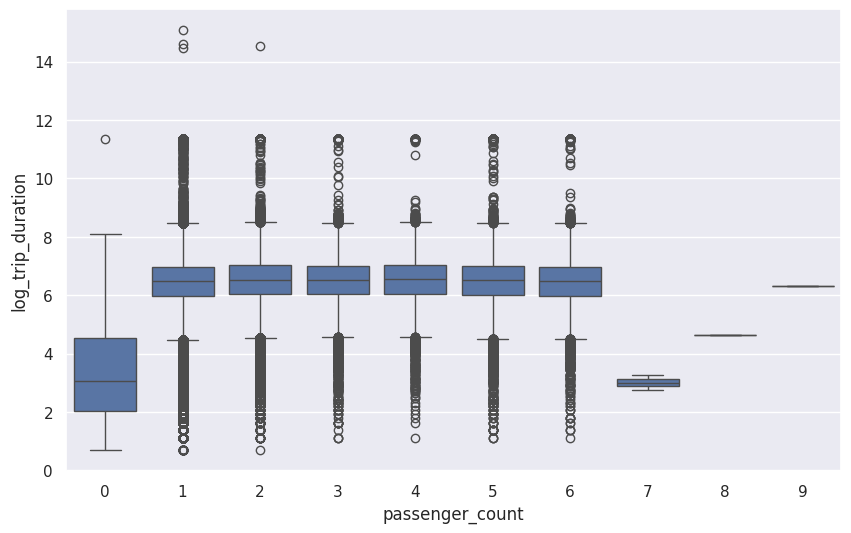

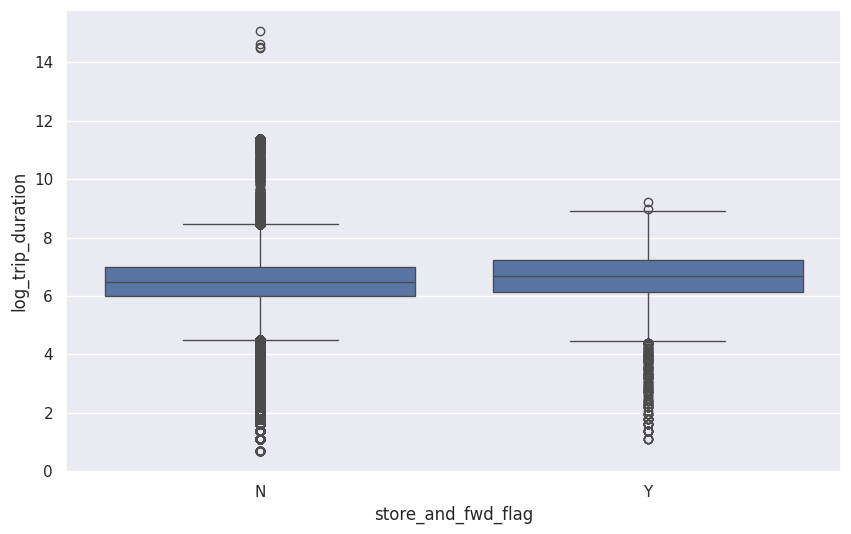

In [51]:
for i in ['vendor_id','passenger_count','store_and_fwd_flag']:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=i, y='log_trip_duration', data=df)


#DROP

# Переведите признаки `vendor_id` и `store_and_fwd_flag` в значения $\{0;1\}$

In [52]:
# Преобразование vendor_id в значения {0, 1}
df['vendor_id'] = df['vendor_id'].map({1: 0, 2: 1})

# Преобразование store_and_fwd_flag в значения {0, 1}
df['store_and_fwd_flag'] = df['store_and_fwd_flag'].map({'N': 0, 'Y': 1})



**Вопрос**: Основываясь на графиках выше, как вы думаете, будут ли эти признаки сильными?

**Task 12**. Проверьте свои предположения, обучив модель в том числе и на этих трех признаках. Обучайте `Ridge`-регрессию со стандартными параметрами. Категориальные признаки закодируйте one-hot-кодированием, а численные отмасштабируйте.

In [53]:
df.drop('id',axis=1,inplace=True)

In [54]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge,Lasso
from sklearn.metrics import mean_squared_log_error

X = df.drop(['log_trip_duration','pickup_longitude', 'pickup_latitude', 'dropoff_latitude', 'dropoff_longitude'], axis=1)
y = df['log_trip_duration']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=23)

numeric_features = X.select_dtypes(include='number').columns.tolist()


categorical_features = X.select_dtypes(include='object').columns.tolist()

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(), categorical_features)
    ])

model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', Ridge())
])

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

rmsle_score = rmsle(y_test, y_pred)
print(f'RMSLE Score: {rmsle_score:.4f}')



RMSLE Score: 0.4850


Если признаки не дали какого-то ощутимого улучшения метрики, их можно выбросить из данных.

In [55]:
collumns_to_drop=['vendor_id','store_and_fwd_flag']
df.drop(collumns_to_drop,axis=1,inplace=True)

## PART 4. Улучшаем модель

**Task 13**. В наших данных есть нетипичные объекты (выбросы, или outliers): с аномально маленьким времени поездки, с очень большим пройденным расстоянием или очень большими остатками регрессии. В этом задании предлагается исключить такие объекты из обучающей выборки. Для этого нарисуйте гистограммы распределения упомянутых выше величин, выберите объекты, которые можно назвать выбросами, и очистите __обучающую выборку__ от них.

Отметим, что хотя эти объекты и выглядят как выбросы, в тестовой выборке тоже скорее всего будут объекты с такими же странными значениями целевой переменной и/или признаков. Поэтому, возможно, чистка обучающей выборки приведёт к ухудшению качества на тесте. Тем не менее, всё равно лучше удалять выбросы из обучения, чтобы модель получалась более разумной и интерпретируемой.

<Axes: xlabel='log_trip_duration', ylabel='Count'>

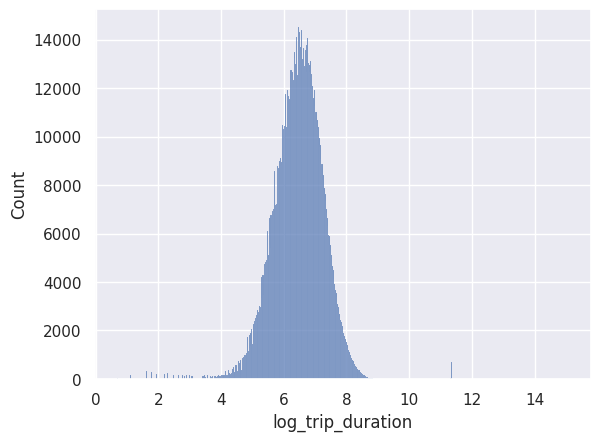

In [56]:
sns.histplot(df['log_trip_duration'])

<Axes: ylabel='log_trip_duration'>

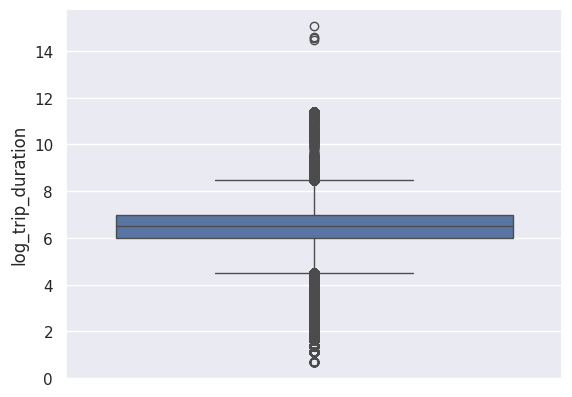

In [57]:
sns.boxplot(df['log_trip_duration'])

<Axes: xlabel='log_haversine', ylabel='Count'>

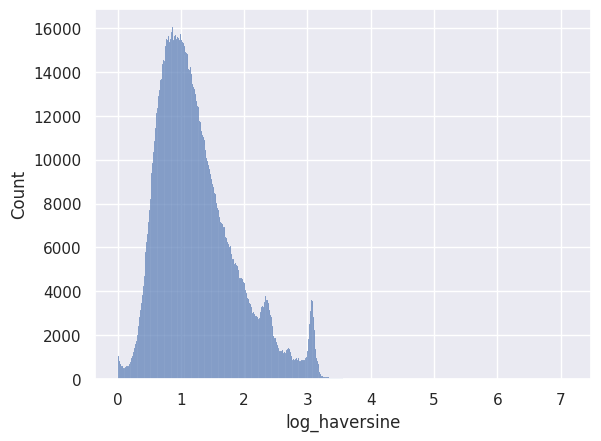

In [58]:
sns.histplot(df['log_haversine'])


<Axes: xlabel='log_trip_duration', ylabel='Count'>

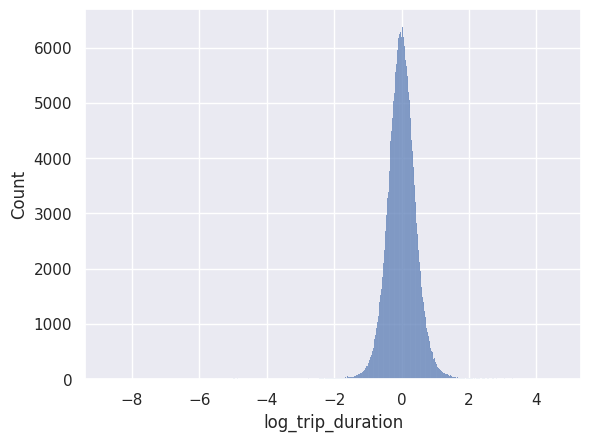

In [59]:
sns.histplot(y_pred-y_test)

In [60]:

lower=df['log_haversine'].quantile(0.01)
upper=df['log_haversine'].quantile(0.99)
df=df[(df['log_haversine']>=lower) & (df['log_haversine']<=upper)]

In [61]:

lower=df['log_trip_duration'].quantile(0.01)
upper=df['log_trip_duration'].quantile(0.99)
df=df[(df['log_trip_duration']>=lower) & (df['log_trip_duration']<=upper)]

#dd

Сейчас у нас очень много категориальных признаков. В категориальных признаках могут содержаться редкие категории, обычно это плохо: модель сильно переобучается на таких примерах. Для каждого категориального признака объедините действительно редкие категории в одну, если такие имеются (т.е. если категории действительно редкие).

In [62]:
df['passenger_count'].value_counts()
df['pickup_cell'].value_counts()
df['dropoff_cell'].value_counts()

,count
dropoff_cell,
14,397071
18,277695
19,208090
10,161151
23,109492
22,52032
-1,46451
27,30251
6,19364


In [63]:
value_counts=df['passenger_count'].value_counts()
df['passenger_count']=df['passenger_count'].map(lambda i:'more_than_6' if value_counts[i]<100 else str(i))


In [64]:
df

,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,log_trip_duration,day_of_week,hour,month,day,anomalous_period_1,anomalous_period_2,log_haversine,rush,traffic,pickup_in_zone_0,dropoff_in_zone_0,pickup_in_zone_1,dropoff_in_zone_1,pickup_in_zone_2,dropoff_in_zone_2,pickup_in_zone_3,dropoff_in_zone_3,pickup_in_zone_4,dropoff_in_zone_4,pickup_in_zone_5,dropoff_in_zone_5,pickup_cell,dropoff_cell,passenger_count_cat
0,1,-73.982155,40.767937,-73.964630,40.765602,6.122493,Monday,17,March,74,0,0,0.917159,0,0,1,1,0,0,0,0,0,0,1,1,1,1,18,19,1
1,1,-73.980415,40.738564,-73.999481,40.731152,6.498282,Sunday,0,June,164,0,0,1.032707,0,1,1,1,0,0,1,1,0,0,1,0,1,1,14,14,1
2,1,-73.979027,40.763939,-74.005333,40.710087,7.661527,Tuesday,11,January,19,0,0,1.998731,0,0,1,1,0,0,0,1,0,0,1,0,1,1,18,10,1
3,1,-74.010040,40.719971,-74.012268,40.706718,6.063785,Wednesday,19,April,97,0,0,0.909722,0,1,1,1,0,0,1,1,0,0,0,0,1,1,10,10,1
4,1,-73.973053,40.793209,-73.972923,40.782520,6.077642,Saturday,13,March,86,0,0,0.782548,0,1,1,1,0,0,0,0,0,0,1,1,0,0,22,22,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1458639,4,-73.982201,40.745522,-73.994911,40.740170,6.658011,Friday,13,April,99,0,0,0.800696,0,0,1,1,0,0,1,1,0,0,1,1,1,1,14,14,4
1458640,1,-74.000946,40.747379,-73.970184,40.796547,6.486161,Sunday,7,January,10,0,0,1.952490,1,0,1,1,0,0,1,0,0,0,0,1,1,0,14,23,1
1458641,1,-73.959129,40.768799,-74.004433,40.707371,6.639876,Friday,6,April,113,0,0,2.177196,1,0,1,1,0,0,0,1,0,0,1,0,1,1,19,10,1
1458642,1,-73.982079,40.749062,-73.974632,40.757107,5.924256,Tuesday,15,January,5,0,0,0.738371,0,0,1,1,0,0,1,0,0,0,1,1,1,1,14,18,1


In [65]:
df.drop(['passenger_count_cat'],axis=1,inplace=True)

Обучите модель на очищенных данных и посчитайте качество на тестовой выборке. Помните, про подбор гиперпараметра `alpha`

In [66]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge, Lasso
from sklearn.metrics import mean_squared_log_error
from sklearn.model_selection import cross_val_score

X = df.drop(['log_trip_duration', 'pickup_longitude', 'pickup_latitude',
             'dropoff_latitude', 'dropoff_longitude'], axis=1)
y = df['log_trip_duration']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=23)

numeric_features = X.select_dtypes(include='number').columns.tolist()
categorical_features = X.select_dtypes(include='object').columns.tolist()


preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(), categorical_features)
    ])

model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', Ridge())
])


param_grid = {'regressor__alpha': [0.01, 0.1, 1, 10, 100]}
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_squared_log_error')

grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

rmsle_score = rmsle(y_test, y_pred)
print(f'Лучший alpha: {grid_search.best_params_["regressor__alpha"]}')
print(f'RMSLE Score: {rmsle_score:.4f}')


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 371, in _score
    y_pred = method_caller(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 89, in _cached_call
    result, _ = _get_response_values(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/utils/_response.py", line 239, in _get_response_values
    y_pred, pos_label = predic

Лучший alpha: 0.01
RMSLE Score: 0.3910


In [67]:
df['pickup_cell'].value_counts()

,count
pickup_cell,
14,451150
18,294303
19,219235
10,169898
23,98403
-1,52994
22,52489
27,14935
15,12349


**Task 14**. После OneHot-кодирования количество признаков в нашем датасете сильно возрастает. Посчитайте колиество признаков до и после кодирования категориальных признаков.

In [68]:
from sklearn.preprocessing import OneHotEncoder

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(), categorical_features),
        ('num', StandardScaler(), numeric_features)
    ])

X_transformed = preprocessor.fit_transform(X)

print(f"Количество признаков до кодирования: {X.shape[1]}")
print(f"Количество признаков после кодирования: {X_transformed.shape[1]}")


Количество признаков до кодирования: 24
Количество признаков после кодирования: 108


Попробуйте обучить не `Ridge`-, а `Lasso`-регрессию. Какой метод лучше?

In [69]:

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder,MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge, Lasso
from sklearn.metrics import mean_squared_log_error
from sklearn.model_selection import cross_val_score


X = df.drop(['log_trip_duration', 'pickup_longitude', 'pickup_latitude',
             'dropoff_latitude', 'dropoff_longitude'], axis=1)
y = df['log_trip_duration']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=23)

numeric_features = X.select_dtypes(include='number').columns.tolist()

categorical_features = X.select_dtypes(include='object').columns.tolist()


preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(), categorical_features)
    ])
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', Lasso())
])

param_grid = {'regressor__alpha': np.linspace(0.001, 1, 20)}
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_squared_log_error')

grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

rmsle_score = rmsle(y_test, y_pred)
print(f'Лучший alpha: {grid_search.best_params_["regressor__alpha"]}')
print(f'RMSLE Score: {rmsle_score:.4f}')


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 371, in _score
    y_pred = method_caller(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 89, in _cached_call
    result, _ = _get_response_values(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/utils/_response.py", line 239, in _get_response_values
    y_pred, pos_label = predic

Лучший alpha: 0.001
RMSLE Score: 0.3927


Для каждого перебранного `alpha` для Lasso посчитайте количество нулевых весов в модели и нарисуйте график зависимости его от `alpha`. Как сильно придётся потерять в качестве, если мы хотим с помощью Lasso избавиться хотя бы от половины признаков?

In [70]:
zeros=[]
mse_values=[]
for alpha in param_grid['regressor__alpha']:
    model = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', Lasso(alpha=alpha))
    ])
    model.fit(X_train, y_train)
    coefficients = model.named_steps['regressor'].coef_
    mse_values.append(mean_squared_error(y_test, y_pred))
    zeros.append(sum(coefficients==0))



<Axes: >

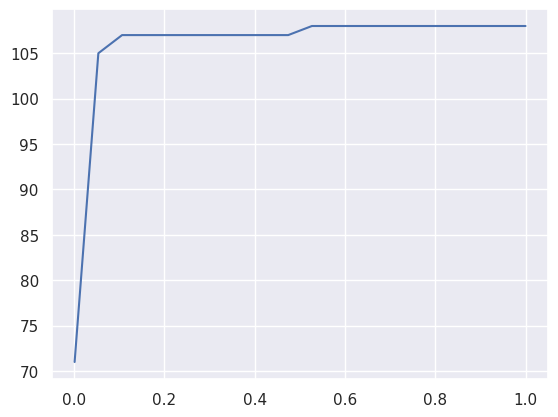

In [71]:
sns.lineplot(x=param_grid['regressor__alpha'],y=zeros)

<img src="https://www.dropbox.com/s/wp4jj0599np17lh/map_direction.png?raw=1" width="20%" align="right" style="margin-left: 20px">

**Task 15**. Часто бывает полезным использовать взаимодействия признаков (feature interactions), то есть строить новые признаки на основе уже существующих. Выше мы разбили карту Манхэттена на ячейки и придумали признаки "из какой ячейки началась поездка" и "в какой ячейке закончилась поездка".

Давайте попробуем сделать следующее: посчитаем, сколько раз встречается каждая возможная пара этих признаков в нашем датасете и выберем 100 самых частых пар. Закодируем поездки с этими частыми парами как категориальный признак, остальным объектам припишем -1. Получается, что мы закодировали, откуда и куда должно было ехать такси.

Также можете придумать ещё какой-нибудь способ сделать признаки про маршрут. Если эти признаки будут давать хороший прирост в качестве, то за это могут быть даны дополнительные бонусные баллы.

**Вопрос**: Почему такой признак потенциально полезный? Почему линейная модель не может самостоятельно "вытащить" эту информацию, ведь у нее в распоряжении есть признаки "из какой ячейки началась поездка" и "в какой ячейке закончилась поездка"?

In [72]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=23)

Заново обучите модель (`Ridge`, если она дала более высокое качество в предыдущих экспериментах, и `Lasso` иначе) на новых даннных и посчитайте качество на тестовой выборке

In [73]:
top_100_routes = (
    X.groupby(['pickup_cell', 'dropoff_cell'])['passenger_count']
    .count()
    .sort_values(ascending=False)
    .head(100)
    .index
)

def encode_route(row):
    if (row['pickup_cell'], row['dropoff_cell']) in top_100_routes:
        return f"{row['pickup_cell']}-{row['dropoff_cell']}"
    else:
        return '-1'

X['encoded_route'] = X.apply(encode_route, axis=1)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=23)

numeric_features = X.select_dtypes(include='number').columns.tolist()
categorical_features = X.select_dtypes(include='object').columns.tolist()

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(), categorical_features)
    ])

model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', Ridge())
])

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

rmsle_score = rmsle(y_test, y_pred)
print(f'RMSLE Score: {rmsle_score:.4f}')


RMSLE Score: 0.3825


In [74]:
X.drop('encoded_route',axis=1,inplace=True)

**Task 16**. Где, как не для нашей задачи, считать манхэттенское расстояние?

**Вопрос**: Найдите, что такое манхэттенское расстояние и почему оно так называется. Как оно нам может помочь?

Введите систему координат на нашей карте так, чтобы оси были параллельны улицам Манхэттена, и добавьте сначала в данные признак "манхэттенское расстояние между пунктом отправления и пунктом назначения", а затем и логарифм этого признака. Посчитайте корреляцию между вашим новыми признаком и таргетом; между `log_haversine` и таргетом. В каком случае корреляция больше?

Нарисуйте карту, где покажете выбранные оси. Чтобы мы могли проверить вашу работу, просьба сделать скрин этой карты и приложить картинку (если мы откроем ваш ноутбук, виджеты отображаться не будут).

In [75]:
import math
import pandas as pd

central_lat=40.748460
central_lon= -73.984559

lat1, lon1=40.756503, -73.978698
lat2, lon2=40.738985, -73.991482

delta_lat = lat2 - lat1
delta_lon = lon2 - lon1

angle_rad= math.atan2(delta_lon, delta_lat)

df['pickup_manhattan_x'] = (df['pickup_latitude'] - central_lat) * math.cos(angle_rad) + (df['pickup_longitude'] - central_lon) * math.sin(angle_rad)
df['pickup_manhattan_y'] = -(df['pickup_latitude'] - central_lat) * math.sin(angle_rad) + (df['pickup_longitude'] - central_lon) * math.cos(angle_rad)
df['dropoff_manhattan_x'] = (df['dropoff_latitude'] - central_lat) * math.cos(angle_rad) + (df['dropoff_longitude'] - central_lon) * math.sin(angle_rad)
df['dropoff_manhattan_y'] = -(df['dropoff_latitude'] - central_lat) * math.sin(angle_rad) + (df['dropoff_longitude'] - central_lon) * math.cos(angle_rad)
df['manhattan_distance'] = abs(df['pickup_manhattan_x'] - df['dropoff_manhattan_x']) + abs(df['pickup_manhattan_y'] - df['dropoff_manhattan_y'])
df['log_manhattan_distance'] = df['manhattan_distance'].apply(lambda x: math.log(x) if x > 0 else 0)

correlation_manhattan = df['manhattan_distance'].corr(df['log_trip_duration'])
correlation_log_manhattan = df['log_manhattan_distance'].corr(df['log_trip_duration'])

print("Корреляция между манхэттенским расстоянием и таргетом:", correlation_manhattan)
print("Корреляция между логарифмом манхэттенского расстояния и таргетом:", correlation_log_manhattan)

print(df)



Корреляция между манхэттенским расстоянием и таргетом: 0.642727385044301
Корреляция между логарифмом манхэттенского расстояния и таргетом: 0.7898816058576645
        passenger_count  pickup_longitude  pickup_latitude  dropoff_longitude  \
0                     1        -73.982155        40.767937         -73.964630   
1                     1        -73.980415        40.738564         -73.999481   
2                     1        -73.979027        40.763939         -74.005333   
3                     1        -74.010040        40.719971         -74.012268   
4                     1        -73.973053        40.793209         -73.972923   
...                 ...               ...              ...                ...   
1458639               4        -73.982201        40.745522         -73.994911   
1458640               1        -74.000946        40.747379         -73.970184   
1458641               1        -73.959129        40.768799         -74.004433   
1458642               1        -

In [76]:
df=df.drop(['pickup_manhattan_x','pickup_manhattan_y','dropoff_manhattan_x','dropoff_manhattan_y','manhattan_distance'],axis=1)


In [77]:
import folium

central_lat, central_lon = 40.748460, -73.984559
lat1, lon1 = 40.756503, -73.978698
lat3, lon3 = 40.752187, -73.993417

def extend_line(lat_start, lon_start, lat_end, lon_end, distance):
    d_lat = lat_end - lat_start
    d_lon = lon_end - lon_start
    new_lat1 = lat_start - distance * d_lat
    new_lon1 = lon_start - distance * d_lon
    new_lat2 = lat_end + distance * d_lat
    new_lon2 = lon_end + distance * d_lon
    return [(new_lat1, new_lon1), (new_lat2, new_lon2)]

extended_line_1 = extend_line(central_lat, central_lon, lat1, lon1, distance=5)
extended_line_2 = extend_line(central_lat, central_lon, lat3, lon3, distance=2)

m = folium.Map(location=[central_lat, central_lon], zoom_start=15)

folium.PolyLine(extended_line_1, color="red", weight=2.5).add_to(m)

folium.PolyLine(extended_line_2, color="blue", weight=2.5).add_to(m)

m


In [78]:

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder,MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge, Lasso
from sklearn.metrics import mean_squared_log_error
from sklearn.model_selection import cross_val_score

X = df.drop(['log_trip_duration', 'pickup_longitude', 'pickup_latitude',
             'dropoff_latitude', 'dropoff_longitude','log_haversine'], axis=1)
y = df['log_trip_duration']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=23)

numeric_features = X.select_dtypes(include='number').columns.tolist()
categorical_features = X.select_dtypes(include='object').columns.tolist()


preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(), categorical_features)
    ])
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', Lasso())
])

param_grid = {'regressor__alpha': np.linspace(0.001, 1, 20)}
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_squared_log_error')

grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

rmsle_score = rmsle(y_test, y_pred)
print(f'Лучший alpha: {grid_search.best_params_["regressor__alpha"]}')
print(f'RMSLE Score: {rmsle_score:.4f}')


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 371, in _score
    y_pred = method_caller(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 89, in _cached_call
    result, _ = _get_response_values(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/utils/_response.py", line 239, in _get_response_values
    y_pred, pos_label = predic

Лучший alpha: 0.001
RMSLE Score: 0.3753


Заново обучите модель на новых даннных и посчитайте качество на тестовой выборке. Стало ли лучше? Объясните полученный результат.

**Task 17**. Реализуйте трансформер, который строит разбиение карты по шестигранной решётке с помощью библиотеки [H3](https://github.com/uber/h3-py) и вычисляет признаки на основе такого разбиения.

Признаки могут быть самые разные: расстояние между точкой старта и финиша, посчитанное в количестве шестиугольников; статистика по числу поездок и по их продолжительности в соседних шестиугольниках.

Важно: производительность библиотеки существенно зависит от количества шестиугольников на карте (определяется параметром resolution). Подберите такое разрешение, при котором ваш код будет работать за приемлемое время.

При построении признаков старайтесь не допустить утечки целевой переменной (подробнее про это можно почитать в материалах 1-го семинара) — в противном случае хорошего качества на тестовой выборке достичь не получится.

Измерьте качество после добавления новых признаков. Кто доберется до этого этапа, получит ПИЦЦУ!

In [79]:
pip install --upgrade h3


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.5/993.5 kB 14.6 MB/s eta 0:00:00


In [80]:
import h3
import pandas as pd
import numpy as np

class HexagonTransformer:
    def __init__(self, resolution=7):
        self.resolution = resolution

    def transform(self, df):
        df['pickup_hex'] = df.apply(lambda row: h3.latlng_to_cell(row['pickup_latitude'], row['pickup_longitude'], self.resolution), axis=1)
        df['dropoff_hex'] = df.apply(lambda row: h3.latlng_to_cell(row['dropoff_latitude'], row['dropoff_longitude'], self.resolution), axis=1)

        df['hex_distance'] = df.apply(lambda row: h3.grid_distance(row['pickup_hex'], row['dropoff_hex']), axis=1)

        pickup_counts = df['pickup_hex'].value_counts().to_dict()
        df['pickup_trip_count'] = df['pickup_hex'].map(pickup_counts)

        dropoff_counts = df['dropoff_hex'].value_counts().to_dict()
        df['dropoff_trip_count'] = df['dropoff_hex'].map(dropoff_counts)

        df['pickup_avg_log_haversine'] = df.groupby('pickup_hex')['log_haversine'].transform('mean')
        df['dropoff_avg_log_haversine'] = df.groupby('dropoff_hex')['log_haversine'].transform('mean')
        df['pickup_avg_log_manhattan'] = df.groupby('pickup_hex')['log_manhattan_distance'].transform('mean')
        df['dropoff_avg_log_manhattan'] = df.groupby('dropoff_hex')['log_manhattan_distance'].transform('mean')

        df.fillna(0, inplace=True)
        df.drop(['pickup_hex', 'dropoff_hex'], axis=1, inplace=True)

        return df

transformer = HexagonTransformer(resolution=8)
df_transformed = transformer.transform(df)

print(df_transformed.head())


  passenger_count  pickup_longitude  pickup_latitude  dropoff_longitude  \
0               1        -73.982155        40.767937         -73.964630   
1               1        -73.980415        40.738564         -73.999481   
2               1        -73.979027        40.763939         -74.005333   
3               1        -74.010040        40.719971         -74.012268   
4               1        -73.973053        40.793209         -73.972923   

   dropoff_latitude  log_trip_duration day_of_week  hour    month  day  \
0         40.765602           6.122493      Monday    17    March   74   
1         40.731152           6.498282      Sunday     0     June  164   
2         40.710087           7.661527     Tuesday    11  January   19   
3         40.706718           6.063785   Wednesday    19    April   97   
4         40.782520           6.077642    Saturday    13    March   86   

   anomalous_period_1  anomalous_period_2  log_haversine  rush  traffic  \
0                   0        

In [81]:
df.head(10)


,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,log_trip_duration,day_of_week,hour,month,day,anomalous_period_1,anomalous_period_2,log_haversine,rush,traffic,pickup_in_zone_0,dropoff_in_zone_0,pickup_in_zone_1,dropoff_in_zone_1,pickup_in_zone_2,dropoff_in_zone_2,pickup_in_zone_3,dropoff_in_zone_3,pickup_in_zone_4,dropoff_in_zone_4,pickup_in_zone_5,dropoff_in_zone_5,pickup_cell,dropoff_cell,log_manhattan_distance,hex_distance,pickup_trip_count,dropoff_trip_count,pickup_avg_log_haversine,dropoff_avg_log_haversine,pickup_avg_log_manhattan,dropoff_avg_log_manhattan
0,1,-73.982155,40.767937,-73.964630,40.765602,6.122493,Monday,17,March,74,0,0,0.917159,0,0,1,1,0,0,0,0,0,0,1,1,1,1,18,19,-3.730658,2,30751,34596,1.170126,1.026401,-3.674519,-3.881403
1,1,-73.980415,40.738564,-73.999481,40.731152,6.498282,Sunday,0,June,164,0,0,1.032707,0,1,1,1,0,0,1,1,0,0,1,0,1,1,14,14,-3.566378,3,20406,27118,1.168510,1.109668,-3.687490,-3.753746
2,1,-73.979027,40.763939,-74.005333,40.710087,7.661527,Tuesday,11,January,19,0,0,1.998731,0,0,1,1,0,0,0,1,0,0,1,0,1,1,18,10,-2.666382,8,60871,16419,1.196677,1.486824,-3.633866,-3.306740
3,1,-74.010040,40.719971,-74.012268,40.706718,6.063785,Wednesday,19,April,97,0,0,0.909722,0,1,1,1,0,0,1,1,0,0,0,0,1,1,10,10,-4.015684,2,20464,10158,1.334848,1.610337,-3.477132,-3.162975
4,1,-73.973053,40.793209,-73.972923,40.782520,6.077642,Saturday,13,March,86,0,0,0.782548,0,1,1,1,0,0,0,0,0,0,1,1,0,0,22,22,-4.202150,1,21382,9780,1.195746,1.127935,-3.668423,-3.728486
5,6,-73.982857,40.742195,-73.992081,40.749184,6.095825,Saturday,22,January,30,0,0,0.741759,0,1,1,1,0,0,1,1,0,0,1,1,1,1,14,14,-4.441494,1,54702,63289,1.143671,1.064726,-3.722258,-3.798268
6,4,-73.969017,40.757839,-73.957405,40.765896,5.834811,Friday,22,June,169,0,0,0.844721,0,1,1,1,0,0,0,0,0,0,1,1,1,1,19,19,-4.018293,2,69270,19780,1.157882,1.156667,-3.692049,-3.621869
7,1,-73.969276,40.797779,-73.922470,40.760559,7.347300,Saturday,7,May,142,0,0,1.904792,1,0,1,1,0,0,0,0,0,1,1,1,0,1,23,20,-2.777021,8,7650,1662,1.246080,1.613270,-3.629079,-2.878492
8,1,-73.999481,40.738400,-73.985786,40.732815,5.545177,Friday,23,May,148,0,0,0.838355,0,1,1,1,0,0,1,1,0,0,0,1,1,1,14,14,-4.022055,1,37297,30331,1.118357,1.092554,-3.759663,-3.796318
9,1,-73.981049,40.744339,-73.973000,40.789989,7.111512,Thursday,21,March,70,0,0,1.810713,0,1,1,1,0,0,1,0,0,0,1,1,1,0,14,22,-2.780157,6,48489,21127,1.146590,1.189060,-3.718608,-3.683749


In [82]:
X = df.drop(['log_trip_duration', 'pickup_longitude', 'pickup_latitude',
             'dropoff_latitude', 'dropoff_longitude'], axis=1)
y = df['log_trip_duration']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=23)

numeric_features = X.select_dtypes(include='number').columns.tolist()

categorical_features = X.select_dtypes(include='object').columns.tolist()


preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(), categorical_features)
    ])
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', Lasso())
])

param_grid = {'regressor__alpha': np.linspace(0.001, 1, 20)}
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_squared_log_error')

grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_

y_pred = best_model.predict(X_test)

rmsle_score = rmsle(y_test, y_pred)
print(f'Лучший alpha: {grid_search.best_params_["regressor__alpha"]}')
print(f'RMSLE Score: {rmsle_score:.4f}')


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 371, in _score
    y_pred = method_caller(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 89, in _cached_call
    result, _ = _get_response_values(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/utils/_response.py", line 239, in _get_response_values
    y_pred, pos_label = predic

Лучший alpha: 0.001
RMSLE Score: 0.3721


# ИТОГ

Данная работа - это ваше ЛИЧНОЕ исследование, которое является весомым вкладом в ваше ПОРТФОЛИО. Сохраните этот колаб у себя на GitHub!

Также лучшую из моделей (Pipeline) в виде файла `.pkl` со всем необходимым кодом предобработки данных разместите у себя в репозитории, чтобы мы могли запустить и протестить вашу модель на новых данных.